### Find good u and fix it to see if S converges to good result...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import vampnet
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from vampnet import data_generator
import os
from tensorflow.keras.backend import get_session
from tensorflow.keras.layers import Layer
import datetime

### Specify hyperparameters

In [2]:
kT_prinz = 1.
prinz = data_generator.PrinzModel(dt = 0.001, kT = kT_prinz)

# we skip frames to make events rarer so it's harder for the model to identify them
# the trajectory length has > 11 since we want to calculate timescales for up to 10 timesteps
skip = 5
traj_len = 11 * skip
traj_num = 1000


# should be scaled according to trajectory length and number
# the full model and chi requires more training steps
epoch_chi = 300
epoch_S = 10000
epoch_all = epoch_chi * 10


# define starting distribution
starting_dist = np.array([15, 70, 9, 6])
norm_traj_num = np.ceil(starting_dist/starting_dist.sum()*traj_num).astype('int')


# number of output nodes/states of the MSM or Koopman model, therefore also nodes of chi
output_size = 4
# tau list for timescales estimation
tau_list = [1,2,3,4,6,8,10]
number_taus = len(tau_list)

# Tau, how much is the timeshift of the two datasets in the default training
tau = 1

# Batch size for Stochastic Gradient descent
batch_size = 5000

# Which trajectory points percentage is used as training
train_ratio = 0.5

# How many hidden layers the network chi has
network_depth = 6

# Width of every layer of chi
layer_width = 100

# Learning rate used for the ADAM optimizer
learning_rate = 5e-4

# create a list with the number of nodes for each layer
nodes = [layer_width]*network_depth

# epsilon for numerical inversion of correlation matrices
epsilon = 1e-6
# use vampnet functionality for pretraining
vamp = vampnet.VampnetTools(epsilon = epsilon)
# input size of the data
input_size = 1

### Data generation

In [3]:
# function for data generation

def get_short_trajs():
    '''
    Generate a number of short trajectories starting from the state centers for the prinz potential
    Trajectories per state are defined above in norm_traj_num
    Adds noise to starting point of trajectory to avoid a delta-like distribution in the state centers
    '''
    short_trajs = []
    state_centers = (-0.75, -0.25, 0.25, 0.75)
    
    for traj_per_state, state_center in zip(norm_traj_num, state_centers):
        short_trajs += [prinz.sample(state_center + 0.15 * np.random.rand(1), traj_len) for i in range(traj_per_state)]
        
    short_trajs = np.array(short_trajs)
    short_trajs_skip = short_trajs[:,::skip]
    
    
    return short_trajs_skip

def split_lag(data, lag):
    '''
    Splits data from a list of short trajectories into a trajectories and a lagged trajectories lists
    [:, None] adds a dimension to our trajectories which corresponds to input_size = 1
    '''
    traj = np.concatenate([traj[:-lag] for traj in data])[:,None]
    traj_lag = np.concatenate([traj[lag:] for traj in data])[:,None]
    
    return traj, traj_lag


training_trajs = get_short_trajs()
validation_trajs = get_short_trajs()

traj_data_train, traj_data_train_lag = split_lag(training_trajs, tau)
traj_data_valid, traj_data_valid_lag = split_lag(validation_trajs, tau)



# function here too for astype? is astype necessary?

# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')

# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')

# Needs a Y-train set which we dont have.
Y_train = np.zeros((X1_train.shape[0],2*output_size)).astype('float32')
Y_vali = np.zeros((X1_vali.shape[0],2*output_size)).astype('float32')

# store this so that all the data are transformed into a whitened dataset w.r.t. the same mean and std
# we assume a gaussian distribution of our data
train_mean = X1_train.mean(0)
train_std = X1_train.std(0)

# function for whitening data
whiten = lambda x, m = train_mean, s = train_std : (x-m)/s

### Define helper layers for keras

In [4]:
# keras layer that implements the u vector, its constraints, and mu and sigma, along with the three correlation matrices
# the reason for this structure is mostly to comply with keras standards for shape (eg. stacking)
# the structure revolves around a 1xn vector of trainable weights called the "kernel"

class Vamp_matrix_u(Layer):

    def __init__(self, output_dim, transform_kernel, **kwargs):

        self.M = output_dim
        self.acti = transform_kernel

        super(Vamp_matrix_u, self).__init__(**kwargs)

    def build(self, input_shape):
        
        # u has to act as a reweighting factor for the stationary distribution,
        # so we initialize it equally for all states

        self.u_kernel = self.add_weight(name='u_var', 
                                shape=(self.M,),
                                 initializer=tf.constant_initializer(1/output_size),
                                 trainable=True)

        super(Vamp_matrix_u, self).build(input_shape)

    # function required by keras, has to return the shape of the outputs
    def compute_output_shape(self, input_shape):
        return [(self.M), (self.M), (self.M, self.M), (self.M, self.M), (self.M, self.M), (self.M, self.M), (self.M)]

    # the call function accepts as input the transformed chi_t and chi_tau trajectories,
    # normalizes u accordingly and calculates mu, sigma and the other elements necessary
    # for the futher computation blocks
    
    def call(self, x):

        chi_t, chi_tau = x
        
        # we need batchsize to stack the outputs later so that it fullfills keras' requirements
        batchsize_int = tf.shape(chi_t)[0]
        batchsize = tf.to_float(batchsize_int)

        # note: corr_tau is the correlation matrix of the time-shifted data
        # presented in the paper at page 6, "Normalization of transition density"
        corr_tau = 1./batchsize * tf.matmul(chi_tau, chi_tau, transpose_a=True)
        chi_mean = tf.reduce_mean(chi_tau, axis=0, keepdims=True)

        kernel_u = tf.expand_dims(self.acti(self.u_kernel), axis=0)

        # u is the normalized and transformed kernel of this layer
        u = kernel_u / tf.reduce_sum(chi_mean * kernel_u, keepdims=True)

        v = tf.matmul(corr_tau, u, transpose_b=True)

        mu = 1./batchsize * tf.matmul(chi_tau, u, transpose_b=True)
        Sigma =  tf.matmul(chi_tau * mu, chi_tau, transpose_a=True)

        gamma = chi_tau * (tf.matmul(chi_tau, u, transpose_b=True))

        C_00 = 1./batchsize * tf.matmul(chi_t, chi_t, transpose_a=True)
        C_11 = 1./batchsize * tf.matmul(gamma, gamma, transpose_a=True)
        C_01 = 1./batchsize * tf.matmul(chi_t, gamma, transpose_a=True)

        
        # stack outputs so that the first dimension is = batchsize, keras requirement
        def tile_for_keras(x):
            x_exp = tf.expand_dims(x, axis=0)
            x_shape = x.get_shape().as_list()
            ones = [1] * len(x_shape)
            stack_x = tf.tile(x_exp, [batchsize_int, *ones])
            
            return stack_x

        ret = [
            tile_for_keras(u),
            tile_for_keras(v),
            tile_for_keras(C_00),
            tile_for_keras(C_11),
            tile_for_keras(C_01),
            tile_for_keras(Sigma),
            mu
        ]

        return ret

In [5]:
# keras layer that implements the S matrix and its constraints, and calculates the K matrix

class Vamp_matrix_S(Layer):

    def __init__(self, output_dim, transform_kernel, renorm = False, **kwargs):
        # renorm forces the S values to be positive
        self.M = output_dim
        self.acti = transform_kernel
        self.renorm = renorm

        super(Vamp_matrix_S, self).__init__(**kwargs)

    def build(self, input_shape):

        self.S_kernel = self.add_weight(name='S_var', 
                                shape=(self.M,self.M),
                                 initializer=tf.constant_initializer(.1),
                                 trainable=True)

        super(Vamp_matrix_S, self).build(input_shape)

    # function required by keras, has to return the shape of the outputs
    def compute_output_shape(self, input_shape):
        return [(self.M, self.M), (self.M, self.M), (self.M), (self.M, self.M)]

    # this function has two different behaviours distinguished through how many parameters are passed in the input list
    # for len(x) == 8 it is used to train the full network, with the data being transformed through chi first
    # for len(x) == 5 it is used to train only S with a full batch of data, thus the two chis aren't necessary anymore
    # training is faster for len(x) == 5 since it requires less calculations
    def call(self, x):

        # unpack input list for the 2 cases
        # selects the first elements of the inputs due to keras batchsize input requirement
        
        if len(x) == 5:
            v, C_00, C_11, C_01, Sigma = x
        else:
            chi_t, chi_tau, u, v, C_00, C_11, C_01, Sigma = x
            u = u[0]
            
        batchsize_int = tf.shape(v)[0]
        batchsize = tf.to_float(batchsize_int)
        C_00 = C_00[0]
        C_11 = C_11[0]
        C_01 = C_01[0]
        Sigma = Sigma[0]
        v = v[0]

        # transform the kernel weights
        kernel_w = self.acti(self.S_kernel)

        # enforce symmetry
        W1 = kernel_w + tf.transpose(kernel_w)

        # normalize the weights
        norm = W1 @ v
        
        if self.renorm:
            # make sure that the largest value of norm is < 1
            quasi_inf_norm = lambda x: tf.reduce_sum((x**20))**(1./20)
            W1 = W1 / quasi_inf_norm(norm)
            norm = W1 @ v

        
        w2 = (1 - tf.squeeze(norm)) / tf.squeeze(v)
        S = W1 + tf.diag(w2)

        # calculate the probabilities to observe the data pair
        if len(x) == 8:
            q =  tf.transpose(tf.matmul(S, chi_tau, transpose_b=True)) * tf.matmul(chi_tau, u, transpose_b=True) / batchsize
            probs = tf.reduce_sum(chi_t * q, axis=1) 

        # calculate K
        K = S @ Sigma

        # VAMP-E matrix for the computation of the loss
        VampE_matrix = tf.transpose(S) @ C_00 @ S @ C_11 - 2*tf.transpose(S) @ C_01

        # stack outputs so that the first dimension is = batchsize, keras requirement
        VampE_matrix_tile = tf.tile(tf.expand_dims(VampE_matrix, axis=0), [batchsize_int,1,1])
        K_mult = tf.tile(tf.expand_dims(K, axis=0), [batchsize_int,1,1])
        S_mult = tf.tile(tf.expand_dims(S, axis=0), [batchsize_int,1,1])

        if len(x) == 5:
            ret = [VampE_matrix_tile, K_mult, tf.zeros((batchsize_int, self.M)), S_mult]
        else:
            ret = [VampE_matrix_tile, K_mult, probs, S_mult] 

        return ret

In [6]:
# we transform the kernels using a linear transformation with very small slope for learning stability
# only for reversible VAMPnets
factor_S = 0.001
factor_u = .000001

linear_S = lambda x: factor_S * x
linear_u = lambda x: factor_u * x

# activations for reversible VAMPnets
acti_S = linear_S
acti_u = linear_u

#activations for revDMSM
acti_S2 = tf.exp
acti_u2 = tf.exp

# define loss functions
maximum_likelihood = lambda x: - tf.reduce_sum( tf.log(y_pred), axis=0)
loss_vampe = lambda y_true, y_pred: tf.trace(y_pred[0])

In [7]:
def estimate_koopman_op(trajs, tau, force_symmetric = False):
    '''Estimates the koopman operator for a given trajectory at the lag time
        specified. The formula for the estimation is:
            K = C00 ^ -1 @ C01

    Parameters
    ----------
    traj: numpy array with size [traj_timesteps, traj_dimensions]
        Trajectory described by the returned koopman operator

    tau: int
        Time shift at which the koopman operator is estimated
        
    force_symmetric: boolean, default = False
        if true, calculates the symmetrized version of K instead

    Returns
    -------
    koopman_op: numpy array with shape [traj_dimensions, traj_dimensions]
        Koopman operator estimated at timeshift tau

    '''
    # if tau larger 0, interpret trajs as either a list of trajectories
    # or a single trajectory
    # otherwise interpret trajs as a list of the data and time-lagged data
    # possibly in random order
    if tau > 0:
        if type(trajs) == list:
            traj = np.concatenate([t[:-tau] for t in trajs], axis = 0)
            traj_lag = np.concatenate([t[tau:] for t in trajs], axis = 0)
        else:
            traj = trajs[:-tau]
            traj_lag = trajs[tau:]
    else:
        traj = traj[0]
        traj_lag = traj[1]
        
        
    koopman_op = np.eye(traj.shape[1])

    c_0 = traj.T @ traj
    c_tau = traj.T @ traj_lag
    
    # if you want to symmetrize the correlation matrices
    if force_symmetric:
        c_0 = c_0 + traj_lag.T @ traj_lag
        c_tau = c_tau + traj_lag.T @ traj

    eigv_all, eigvec_all = np.linalg.eig(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)

    koopman_op = c0_inv @ c_tau

    return koopman_op



# utility function for plotting implied timescales
# the hyperparameters allow for it to calculate errorbars and work from different input data types
def get_its(data, lags, calculate_K = True, multiple_runs = False):
    
    def get_single_its(data):

        if type(data) == list:
            outputsize = data[0].shape[1]
        else:
            outputsize = data.shape[1]

        single_its = np.zeros((outputsize-1, len(lags)))

        for t, tau_lag in enumerate(lags):
            if calculate_K:
                koopman_op = self.estimate_koopman_op(data, tau_lag)
            else:
                koopman_op = data[t]
            k_eigvals, k_eigvec = np.linalg.eig(np.real(koopman_op))
            k_eigvals = np.sort(np.absolute(k_eigvals))
            k_eigvals = k_eigvals[:-1]
            single_its[:,t] = (-tau_lag / np.log(k_eigvals))

        return np.array(single_its)


    if not multiple_runs:

        its = get_single_its(data)

    else:

        its = []
        for data_run in data:
            its.append(get_single_its(data_run))

    return its

# utility function, resets all the weights in the graph    
def reset_weights(var):
    session = get_session()
    var.initializer.run(session=session)

### Define ordinary VAMPnet

In [8]:
# Input layers, through which our trajectory and lagged trajectory will be passed
Data_X_keras = keras.layers.Input(shape = (input_size,))
Data_Y_keras = keras.layers.Input(shape = (input_size,))

# Dense layers that compose the network 
dense_layers = [tf.keras.layers.Dense(node, activation = tf.nn.elu)
                for index_layer,node in enumerate(nodes)]

# Add a softmax output layer.
softmax = tf.keras.layers.Dense(output_size, activation='softmax')

# The layers for trainable vector u and matrix S for the revVAMPnet
vamp_layer_u = Vamp_matrix_u(output_size, acti_u)
vamp_layer_S = Vamp_matrix_S(output_size, acti_S, renorm=False)

# The layers for trainable vector u and matrix S for the revMSM
vamp_layer_u_msm = Vamp_matrix_u(output_size, acti_u2)
vamp_layer_S_msm = Vamp_matrix_S(output_size, acti_S2, renorm=True)

# Assign instance layers to the two lobes of the network
lx_branch_keras = Data_X_keras
rx_branch_keras = Data_Y_keras

# Connect the layers into a network
for i, layer in enumerate(dense_layers):

    lx_branch_keras = dense_layers[i](lx_branch_keras)
    rx_branch_keras = dense_layers[i](rx_branch_keras)


# Connect a softmax output layer.
lx_branch_keras = softmax(lx_branch_keras)
rx_branch_keras = softmax(rx_branch_keras)

# Merge them to use the VAMP loss functions
merged_chi = keras.layers.concatenate([lx_branch_keras, rx_branch_keras]) 

W0115 15:26:16.961718 140414737237760 deprecation.py:506] From /home/andreasmardt/anaconda2/envs/tf15/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Define the network for the revVAMPnet

In [9]:
# Use auxiliary u layer with the output of the network as input
# to build a model wich depends on all variables
tf_u_all, tf_v_all, tf_C_00_all, tf_C_11_all , tf_C_01_all, Sigma_all, mu_all = vamp_layer_u([lx_branch_keras, rx_branch_keras])

# Pass it to the auxiliary S layer which provides all outputs
# for the different losses and to predict the transition matrix
VampE_matrix_all, K_all, probs_all, S_all = vamp_layer_S([lx_branch_keras, rx_branch_keras, tf_u_all, tf_v_all, tf_C_00_all, tf_C_11_all , tf_C_01_all, Sigma_all])

# Define inputs, where the output of the chi network can be fed in 
# in order to train just for u and S without computational overhead
Data_chi_t_keras = keras.layers.Input(shape = (output_size,))
Data_chi_tau_keras = keras.layers.Input(shape = (output_size,))

# Pass it again through the u and S layer starting from the new inputs
tf_u_both, tf_v_both, tf_C_00_both, tf_C_11_both , tf_C_01_both, Sigma_both, _ = vamp_layer_u([Data_chi_t_keras, Data_chi_tau_keras])
VampE_matrix_both, K_both, probs_both, S_both = vamp_layer_S([Data_chi_t_keras, Data_chi_tau_keras, tf_u_both, tf_v_both, tf_C_00_both, tf_C_11_both , tf_C_01_both, Sigma_both])

# Auxiliary inputs to just train for S, where a lot of computational overhead 
# can be reduced
Data_v_keras = keras.layers.Input(shape = (output_size, 1))
Data_C_00_keras = keras.layers.Input(shape = (output_size,output_size))
Data_C_01_keras = keras.layers.Input(shape = (output_size,output_size))
Data_C_11_keras = keras.layers.Input(shape = (output_size,output_size))
Data_Sigma_keras = keras.layers.Input(shape = (output_size,output_size))

# Pass these new inputs just through the S layer
VampE_matrix_S, K_S, _ , S_S= vamp_layer_S([Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras])

# Get access through the shared weights of u and S
var_u = vamp_layer_u.weights
var_S = vamp_layer_S.weights

W0115 15:26:17.675978 140414737237760 deprecation.py:323] From /home/andreasmardt/anaconda2/envs/tf15/lib/python3.6/site-packages/tensorflow/python/autograph/impl/api.py:255: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0115 15:26:17.894759 140414737237760 deprecation_wrapper.py:119] From /home/andreasmardt/anaconda2/envs/tf15/lib/python3.6/site-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.diag is deprecated. Please use tf.linalg.tensor_diag instead.



### Define revDMSM

In [10]:
# Use auxiliary u layer with the output of the network as input
# to build a model wich depends on all variables
tf_u_all_msm, tf_v_all_msm, tf_C_00_all_msm, tf_C_11_all_msm , tf_C_01_all_msm, Sigma_all_msm, mu_all_msm = vamp_layer_u_msm([lx_branch_keras, rx_branch_keras])

# Pass it to the auxiliary S layer which provides all outputs
# for the different losses and to predict the transition matrix
VampE_matrix_all_msm, K_all_msm, probs_all_msm, S_all_msm = vamp_layer_S_msm([lx_branch_keras, rx_branch_keras, tf_u_all_msm, tf_v_all_msm, tf_C_00_all_msm, tf_C_11_all_msm , tf_C_01_all_msm, Sigma_all_msm])

# Pass it again through the u and S layer starting from the auxiliary inputs replacing chi from before
tf_u_both_msm, tf_v_both_msm, tf_C_00_both_msm, tf_C_11_both_msm , tf_C_01_both_msm, Sigma_both_msm, _ = vamp_layer_u_msm([Data_chi_t_keras, Data_chi_tau_keras])
VampE_matrix_both_msm, K_both_msm, probs_both_msm, S_both_msm = vamp_layer_S_msm([Data_chi_t_keras, Data_chi_tau_keras, tf_u_both_msm, tf_v_both_msm, tf_C_00_both_msm, tf_C_11_both_msm , tf_C_01_both_msm, Sigma_both_msm])

# Pass it just through the S layer starting from the auxiliary inputs replacing chi and u from before
VampE_matrix_S_msm, K_S_msm, _ , S_S_msm= vamp_layer_S_msm([Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras])

# Get access through the shared weights of u and S
var_u_msm = vamp_layer_u_msm.weights
var_S_msm = vamp_layer_S_msm.weights

### Define actual models

In [11]:
# Define a normal VAMPnet model, which will be used for pretraining
model_chi = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = merged_chi)
model_chi.compile(keras.optimizers.Adam(learning_rate=learning_rate*.5),
                 vamp._loss_VAMP_sym,
                 metrics = [
                      vamp.metric_VAMP,
                      vamp.metric_VAMP2,])

W0115 15:26:19.145850 140414737237760 deprecation_wrapper.py:119] From /home/andreasmardt/gitreps/deeptime/vampnet/vampnet/vampnet.py:608: The name tf.self_adjoint_eig is deprecated. Please use tf.linalg.eigh instead.

W0115 15:26:19.150459 140414737237760 deprecation.py:323] From /home/andreasmardt/gitreps/deeptime/vampnet/vampnet/vampnet.py:612: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0115 15:26:19.191824 140414737237760 deprecation_wrapper.py:119] From /home/andreasmardt/gitreps/deeptime/vampnet/vampnet/vampnet.py:268: The name tf.svd is deprecated. Please use tf.linalg.svd instead.



### Define models for the revVAMPnet case

In [12]:
# Define a model to predict the stationary distribution mu
model_mu = keras.models.Model(inputs= [Data_X_keras, Data_Y_keras], outputs=mu_all)

In [13]:
# Define a model to train for all parameters with VAMP-E
model_all_vampE = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = VampE_matrix_all)
model_all_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.),
                 loss_vampe,
             )

In [14]:
# Define a model to predict the transition matrix from a model using the whole pipeline
model_K_all = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = K_all)

In [15]:
# Define a model to train only u and S with VAMP-E
model_both_vampE = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = VampE_matrix_both)
model_both_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000),
                 loss_vampe,
                 )

In [16]:
# Define a model to predict the transition matrix omitting the chi network
model_K_both = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = K_both)

In [17]:
# Define a model to predict to get access to the matrix S omitting the chi network
model_S_both = keras.models.Model(inputs =  [Data_chi_t_keras, Data_chi_tau_keras], outputs = S_both)

In [18]:
# Define a helper model to get access to intermediate results
model_input_S = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = [tf_v_both, tf_C_00_both, tf_C_11_both , tf_C_01_both, Sigma_both])

In [19]:
# Define a model to train only for S with VAMP-E
model_S_vampE = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = VampE_matrix_S)
model_S_vampE.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000, ),
                 loss_vampe,
             )

In [20]:
# Define models to predict the transition matrix and the S matrix omitting the chi network and u layer
model_K_S = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = K_S)
model_S_S = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = S_S)

### Define models for the revMSM case

In [21]:
# Define a model to predict the stationary distribution mu
model_mu_msm = keras.models.Model(inputs= [Data_X_keras, Data_Y_keras], outputs=mu_all_msm)

In [22]:
# Define a model to train for all parameters with VAMP-E
model_all_vampE_msm = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = VampE_matrix_all_msm)
model_all_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.),
                 loss_vampe,
             )

In [23]:
# Define a model to predict the transition matrix from a model using the whole pipeline
model_K_all_msm = keras.models.Model(inputs = [Data_X_keras, Data_Y_keras], outputs = K_all_msm)

In [24]:
# Define a model to train only u and S with VAMP-E
model_both_vampE_msm = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = VampE_matrix_both_msm)
model_both_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000),
                 loss_vampe,
                 )

In [25]:
# Define a model to predict the transition matrix omitting the chi network
model_K_both_msm = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = K_both_msm)

In [26]:
# Define a model to predict to get access to the matrix S omitting the chi network
model_S_both_msm = keras.models.Model(inputs =  [Data_chi_t_keras, Data_chi_tau_keras], outputs = S_both_msm)

In [27]:
# Define a helper model to get access to intermediate results
model_input_S_msm = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = [tf_v_both_msm, tf_C_00_both_msm, tf_C_11_both_msm , tf_C_01_both_msm, Sigma_both_msm])

In [28]:
# Define a model to train only for S with VAMP-E
model_S_vampE_msm = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = VampE_matrix_S_msm)
model_S_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*1000, ),
                 loss_vampe,
             )

In [29]:
# Define models to predict the transition matrix and the S matrix omitting the chi network and u layer
model_K_S_msm = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = K_S_msm)
model_S_S_msm = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = S_S_msm)

### Train chi

In [30]:
# define helper function to re-initilize the layers of the chi network
def get_initializers_list(model):
    list_initializers = []
    for layer in model_chi.layers:
        if layer:
            [list_initializers.append(t) for t in layer.variables]
    return list_initializers

In [31]:
# define a function to predict the chi for all short trajectories with just one call 
# to the graphics cards to increase performance
# therefore appropriate reshaping is necessary

def predict(model, trajs):
    resh_traj = trajs.reshape(-1)
    batch_size_traj = resh_traj.shape[0]
    pred = model.predict([whiten(resh_traj), whiten(resh_traj)],batch_size = batch_size_traj)
    pred_arr = pred.reshape(*trajs.shape, 2*output_size)[:,:,:output_size]
    pred_list = [t for t in pred_arr]
    return pred_list

### Define helper functions for building symmetrized VAMP2 model

In [32]:
def loss_VAMP2_autograd_sym(y_true, y_pred):
    '''Calculates the VAMP-2 score with respect to the network lobes while 
    symmetrizing the correlation matrices. Can be used as a loss function
    for keras models.
    Parameters
    ----------
    y_true: tensorflow tensor.
        parameter not needed for the calculation, added to comply with Keras
        rules for loss fuctions format.

    y_pred: tensorflow tensor with shape [batch_size, 2 * output_size]
        output of the two lobes of the network

    Returns
    -------
    loss_score: tensorflow tensor with shape [1].
    '''

    # Remove the mean from the data
    x, y, batch_size, output_size = _prep_data(y_pred) 

    # Calculate the covariance matrices
    cov_01 = 1/(batch_size - 1) * tf.matmul(x, y, transpose_b=True)
    cov_00 = 1/(batch_size - 1) * tf.matmul(x, x, transpose_b=True) 
    cov_11 = 1/(batch_size - 1) * tf.matmul(y, y, transpose_b=True)
    
    cov_00 = 1/2*(cov_00 + cov_11)
    cov_01 = 1/2*(cov_01 + tf.transpose(cov_01))
    
    # Calculate the inverse of the self-covariance matrices
    cov_00_inv = _inv(cov_00, ret_sqrt = True)
    cov_11_inv = cov_00_inv

    vamp_matrix = tf.matmul(tf.matmul(cov_00_inv, cov_01), cov_11_inv)


    vamp_score = tf.norm(vamp_matrix)

    return - tf.square(vamp_score)

def _inv(x, ret_sqrt=False):
    '''Utility function that returns the inverse of a matrix, with the
    option to return the square root of the inverse matrix.
    Parameters
    ----------
    x: numpy array with shape [m,m]
        matrix to be inverted

    ret_sqrt: bool, optional, default = False
        if True, the square root of the inverse matrix is returned instead
    Returns
    -------
    x_inv: numpy array with shape [m,m]
        inverse of the original matrix
    '''

    # Calculate eigvalues and eigvectors
    eigval_all, eigvec_all = tf.self_adjoint_eig(x)

    # Filter out eigvalues below threshold and corresponding eigvectors
    eig_th = tf.constant(epsilon, dtype=tf.float32)
    index_eig = tf.to_int32(eigval_all > eig_th)
    _, eigval = tf.dynamic_partition(eigval_all, index_eig, 2)
    _, eigvec = tf.dynamic_partition(tf.transpose(eigvec_all), index_eig, 2)

    # Build the diagonal matrix with the filtered eigenvalues or square
    # root of the filtered eigenvalues according to the parameter
    eigval_inv = tf.diag(1/eigval)
    eigval_inv_sqrt = tf.diag(tf.sqrt(1/eigval))

    cond_sqrt = tf.convert_to_tensor(ret_sqrt)

    diag = tf.cond(cond_sqrt, lambda: eigval_inv_sqrt, lambda: eigval_inv)

    # Rebuild the square root of the inverse matrix
    x_inv = tf.matmul(tf.transpose(eigvec), tf.matmul(diag, eigvec))

    return x_inv


def _prep_data(data):
    '''Utility function that transorms the input data from a tensorflow - 
    viable format to a structure used by the following functions in the
    pipeline.
    Parameters
    ----------
    data: tensorflow tensor with shape [b, 2*o]
        original format of the data
    Returns
    -------
    x: tensorflow tensor with shape [o, b]
        transposed, mean-free data corresponding to the left, lag-free lobe
        of the network

    y: tensorflow tensor with shape [o, b]
        transposed, mean-free data corresponding to the right, lagged lobe
        of the network

    b: tensorflow float32
        batch size of the data

    o: int
        output size of each lobe of the network

    '''

    shape = tf.shape(data)
    b = tf.to_float(shape[0])
    o = shape[1]//2

    # Split the data of the two networks and transpose it
    x_biased = tf.transpose(data[:,:o])
    y_biased = tf.transpose(data[:,o:])

    # Subtract the mean
    x = x_biased - tf.reduce_mean(x_biased, axis=1, keepdims=True)
    y = y_biased - tf.reduce_mean(y_biased, axis=1, keepdims=True)

    return x, y, b, o

### Train Vampnets

In [33]:
# train a chi model, uses loss_VAMP_sym pretraining for a faster convergence 
# to a probabilistic encoding

model_chi.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*0.1),
    vamp._loss_VAMP_sym,
    metrics = [
              vamp.metric_VAMP,
              vamp.metric_VAMP2,]
)

[reset_weights(v) for v in get_initializers_list(model_chi)]

hist = model_chi.fit([whiten(X1_train), whiten(X2_train)], Y_train ,
                 batch_size = batch_size,
                 epochs = epoch_chi,
                 validation_data=([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
                 verbose=0,
                 shuffle=True)

model_chi.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*0.1),
    vamp.loss_VAMP2_autograd,
    metrics = [
              vamp.metric_VAMP,
              vamp.metric_VAMP2,]
)

hist = model_chi.fit([whiten(X1_train), whiten(X2_train)], Y_train ,
                 batch_size = batch_size,
                 epochs = epoch_chi,
                 validation_data=([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
                 verbose=0,
                 shuffle=True)

### Plot $\chi$ output

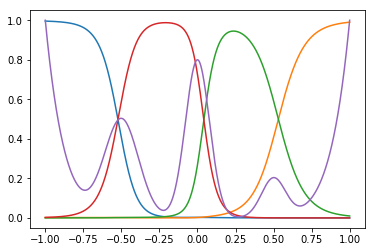

In [34]:
# plot the chi function

pred_ord_chi = predict(model_chi, training_trajs)

xax = np.linspace(-1, 1, 10000)
pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
for i in range(output_size):
    plt.plot(xax, pred_xax[:,i])
pot = data_generator.prinz_energy(xax)
plt.plot(xax, pot / pot.max())
plt.show()

In [35]:
np.save('../vampnet_wip/prinz_traj_test', pred_ord_chi)
np.save('../vampnet_wip/prinz_pred_xax_test', pred_xax)

In [35]:
# Save weights to reuse as initialization of training other models
weights_chi = model_chi.get_weights()

### Train symVAMPnet

In [36]:
model_chi.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*1),
    loss_VAMP2_autograd_sym,
    metrics = [
              loss_VAMP2_autograd_sym,
              vamp.metric_VAMP,
    ]
)

[reset_weights(v) for v in get_initializers_list(model_chi)]

model_chi.set_weights(weights_chi)

hist = model_chi.fit([whiten(X1_train), whiten(X2_train)], Y_train ,
                 batch_size = batch_size,
                 epochs = epoch_chi,
                 validation_data=([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
                 verbose=0,
                 shuffle=True)

### Plot $\chi$ output

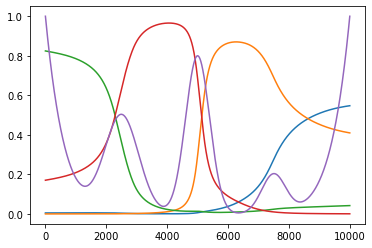

In [37]:
pred_ord_chi = predict(model_chi, training_trajs)

xax = np.linspace(-1, 1, 10000)
pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
for i in range(output_size):
    plt.plot(pred_xax[:,i])
pot = data_generator.prinz_energy(xax)
plt.plot(pot / pot.max())
plt.show()

score_vamp_sym = model_chi.evaluate([whiten(X1_vali), whiten(X2_vali)],  batch_size=batch_size, verbose = 0)[-1]

### Save weights for later analysis

In [38]:
# weights_chi_sym = model_chi.get_weights()

### Get mu and implied timescales for symVAMPnet


In [39]:
# estimate the transition matrix while enforcing the symmetric counts for the correlation matrices
K_mat_sym = estimate_koopman_op(pred_ord_chi, tau, force_symmetric = True)
# estimate the covariance matrix non symmetric
C00 = np.concatenate(pred_ord_chi, axis=0).T @ np.concatenate(pred_ord_chi, axis=0)
# estimate the helper matrix according to the following paper:
# https://arxiv.org/pdf/1610.06773, eq. 32
shifted_K_sym = np.linalg.inv(C00) @ K_mat_sym.T @ C00

In [40]:
# estimate the eigenvector of that matrix with eigenvalue 1
ev, ew = np.linalg.eig(shifted_K_sym)
u_vec = ew[:,np.argmin((ev-1)**2)]
# estimate the stationary distribution
mu_result_sym = np.concatenate(pred_ord_chi, axis=0) @ u_vec
# normalize the stationary distribution
mu_result_sym = mu_result_sym / mu_result_sym.sum()

In [41]:
# estimate the stationary distribution according to the model via the energy
xax = np.linspace(-1,1,10000)
prinz_en = data_generator.prinz_energy(xax)
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (xax[1]-xax[0]))

In [42]:
# calculate a density out of the predicted stationary distribution of the symVAMPnet
hist_sym, bin = np.histogram(training_trajs.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_sym)

In [43]:
# estimate the transition matrixes for different taus for the symVAMPnet
K_results = np.ones((len(tau_list) ,output_size, output_size))
for i, tau_i in enumerate(tau_list):
    print(tau_i)
#     K_results_rev[i]= training_for_tau_both(tau_i)
    K_results[i]  = estimate_koopman_op(pred_ord_chi, tau_i, force_symmetric = True)

1
2
3
4
6
8
10


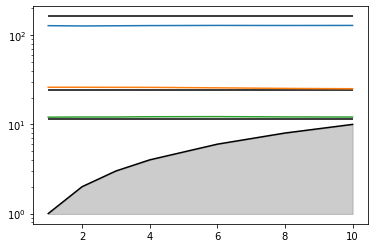

In [44]:
# plot the implied timescales against the true values
timescale_real_values = np.array([ 11.53593249,  24.48666445, 163.41165771])
for tsrv in timescale_real_values:
    plt.hlines(tsrv, tau_list[0], tau_list[-1])
vamp.plot_its(get_its(K_results, tau_list, False), tau_list)

In [45]:
# estimate the eigenvectors of the transition matrix of the symVAMPnet
eigvals_sym, eigvec_sym = np.linalg.eig(K_mat_sym)
sort_ind = np.argsort(eigvals_sym)[::-1]
eigvals_sym = eigvals_sym[sort_ind]
eigvec_sym = eigvec_sym[:,sort_ind]

In [46]:
# load the true eigenfunctions computed with a 
# high resolution MSM and euqilibrium trajectory
data_true = np.load('./True_eigfunc_Prinz.npz')
true_eigfunc = data_true['true_eigfunc']
true_eigvals = data_true['true_eigvals']

### Plot eigenfunctions for symVAMPnet

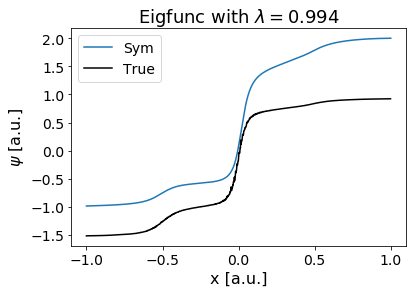

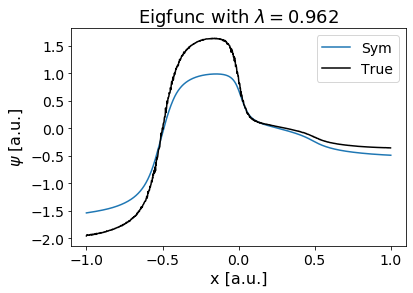

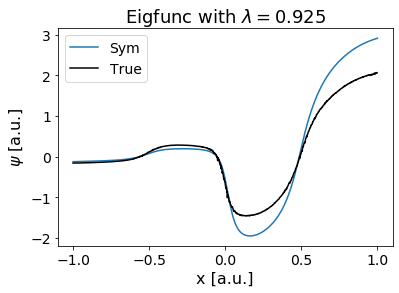

In [47]:
# estimate the eigenfunctions
eigfunc_sym = pred_xax @ eigvec_sym

# plot them against the real once
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={:.3}$'.format(true_eigvals[i]), fontsize=18)
    fac = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac1 = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_sym[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_sym[:,i], label='Sym')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend(fontsize=14)
    plt.xlabel('x [a.u.]', fontsize=16)
    plt.xticks([-1,-.5,0.,.5,1.],fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('$\psi$ [a.u.]', fontsize=16)
    plt.show()

## Training for revVAMPnet

### Initialization of u and S

In [48]:
def optimize_u(factor_u, reset_chi=True):
    ''' 
    Calculate the optimal u for a given chi via a non-reversible Koopman model, 
    and set the kernel of the corresponding layer to the optimal value. 
    This is necessary to stabilize the training.
    Needs to be rewritten if the activation functions for the weights are changed!
    '''
    if reset_chi:
        model_chi.set_weights(weights_chi)
    fullbatch = X1_train.shape[0]
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=fullbatch)
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    fullbatch = Data_chi_X.shape[0]
    
    
    c_0 = 1/fullbatch * Data_chi_X.T @ Data_chi_X
    c_tau = 1/fullbatch * Data_chi_X.T @ Data_chi_Y
    c_1 = 1/fullbatch * Data_chi_Y.T @ Data_chi_Y
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    
    # estimate pi, the stationary distribution vector
    eigv, eigvec = np.linalg.eig(K_vamp.T)
    ind_pi = np.argmin((eigv-1)**2)
    
    pi_vec = eigvec[:,ind_pi]
    pi = pi_vec / np.sum(pi_vec, keepdims=True)
        
    # reverse the consruction of u 
    u_optimal = c0_inv @ pi
    u_kernel = u_optimal / factor_u
    vamp_layer_u.set_weights([u_kernel])
    
    return None

def optimize_S(factor_S, reset_chi=True):
    ''' 
    Calculate the optimal S for a given chi, and set the kernel of the corresponding layer
    to the optimal value. This is necessary to stabilize the training.
    Needs to be rewritten if the activation functions for the weights are changed!
    '''
    if reset_chi:
        model_chi.set_weights(weights_chi)
    fullbatch = X1_train.shape[0]
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=fullbatch)
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    fullbatch = Data_chi_X.shape[0]
    
    
    c_0 = 1/fullbatch * Data_chi_X.T @ Data_chi_X
    c_tau = 1/fullbatch * Data_chi_X.T @ Data_chi_Y
    c_1 = 1/fullbatch * Data_chi_Y.T @ Data_chi_Y
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    
    # get Sigma, invert it to get proxy S, meaning the closest symmetric S you can obtain to the optimal S
    
    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    
    eigv_all, eigvec_all = np.linalg.eigh(Sigma_input[0])
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    sigma_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    # reverse the construction of S
    S_nonrev = K_vamp @ sigma_inv
    S_rev_add = 1/2 * (S_nonrev + S_nonrev.T)
    kernel_S = S_rev_add / 2. / factor_S
    
    vamp_layer_S.set_weights([kernel_S])
        
    return None

In [49]:
optimize_u(factor_u)
optimize_S(factor_S)

### Train $\mathbf{u}$, and $\mathbf{S}$ with full batch

In [50]:
vamp_layer_u.trainable = True
vamp_layer_S.trainable = True

Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])

Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]

Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])

Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]


model_both_vampE.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*10000, clipnorm=1.),
    loss_vampe,
)

hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size=Data_chi_X.shape[0],
                 epochs = epoch_S,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=0,
                 callbacks=[EarlyStopping('val_loss', patience=100, mode='min', restore_best_weights=True)],
                 shuffle=True)

W0113 17:05:08.468381 140620064429888 deprecation.py:323] From /storage/mi/andreasmardt/anaconda3/envs/tf14/lib/python3.7/site-packages/tensorflow/python/ops/clip_ops.py:157: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train $\boldsymbol{\chi}$, $\mathbf{u}$, and $\mathbf{S}$

In [51]:
vamp_layer_u.trainable = True
vamp_layer_S.trainable = True

model_all_vampE.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*0.04,  clipnorm=1.),
    loss_vampe,
)

hist = model_all_vampE.fit(
    [whiten(X1_train), whiten(X2_train)],
    Y_train,
    batch_size = X1_train.shape[0],
    epochs = epoch_all,
    validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
    verbose = 0,
    callbacks = [EarlyStopping('val_loss', patience=100, mode='min', restore_best_weights=True)],
    shuffle = True
)

In [52]:
K_result = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])

### Estimate $\mu$

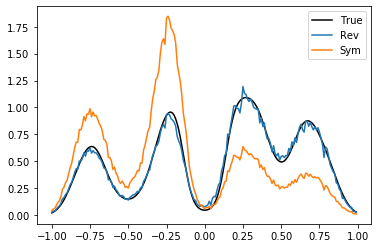

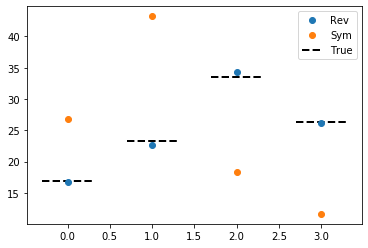

Error of rev: 0.9238958094052178, of sym: 5.0150186078936985


In [53]:
# plot the stationary distribution and compare them to the result of the symVAMPnet

mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])

hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), '.', ms=12, label = "Rev")
plt.plot(np.abs(sym_states_prob), '.', ms=12, label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()

print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

### Estimate eigenfunctions

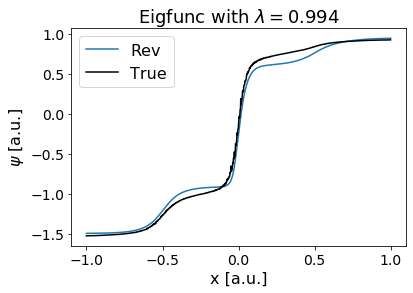

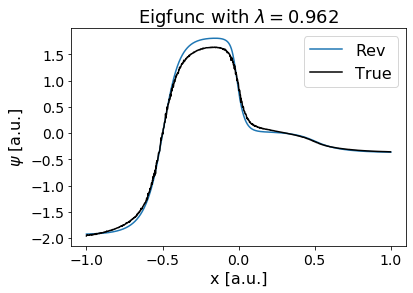

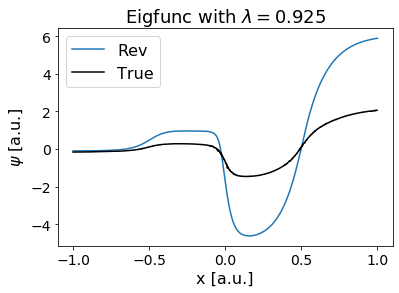

In [54]:
# Estimate the eigenfunctions for the revVAMPnet
K_rev = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev)

sort_ind = np.argsort(eigvals_rev)[::-1]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev1 = pred_xax @ eigvec_rev

for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={:.3}$'.format(true_eigvals[i]), fontsize=18)
    fac = true_eigfunc[0,i] / eigfunc_rev1[0,i]
    fac = true_eigfunc[-1,i] / eigfunc_rev1[-1,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev1[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev1[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_rev1[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend(fontsize=16)
    plt.xlabel('x [a.u.]', fontsize=16)
    plt.xticks([-1.,-.5,0,0.5,1.],fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('$\psi$ [a.u.]', fontsize=16)
    plt.show()

### Training loop with reseting u, stopping criteria via validation set score

In [55]:
# train for an optimal model while resetting u to an optimal solution for the given chi. 
# This should stabilize the training

# starting conditions
score = 0.
weights_all = model_all_vampE.get_weights()
score_old = score


model_both_vampE.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*10000, clipnorm=1.),
    loss_vampe,
)

callbacks = [EarlyStopping('val_loss', patience=100, mode='min', restore_best_weights=True)]

# while the score is not improving of the validation/test set do the following
while (score >= score_old):
    
    # set u to the optimal value
    optimize_u(factor_u, reset_chi=False)

    vamp_layer_u.trainable = True
    vamp_layer_S.trainable = True
    
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    
    Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
    Data_chi_X_vali = Data_chi_vali[:,:output_size]
    Data_chi_Y_vali = Data_chi_vali[:,output_size:]
    
    # train u and S
    hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train ,
                     batch_size = Data_chi_X.shape[0],
                     epochs = epoch_S,
                     validation_data = ([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                     verbose = 0,
                     callbacks = callbacks,
                     shuffle = True)

    # train for all, chi, u, and S
    hist = model_all_vampE.fit(
        [whiten(X1_train), whiten(X2_train)],
        Y_train,
        batch_size = X1_train.shape[0],
        epochs = epoch_all,
        validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
        verbose = 0,
        shuffle = True
    )

    # check if validation score is better than before
    score = - model_all_vampE.evaluate([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0], verbose = 0)
    print('Old score {}, new score {}'.format(score_old, score))
    if (score>score_old):
        print('Score is better and weights are saved')
        score_old = score
        weights_all = model_all_vampE.get_weights()
        
# reset to the best model        
model_all_vampE.set_weights(weights_all)
# optimize once more
optimize_u(factor_u, reset_chi=False)

Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]

Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]

hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size=Data_chi_X.shape[0],
                 epochs = epoch_S,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=0,
                 callbacks=callbacks,
                 shuffle=True)
weights_chi_rev = model_all_vampE.get_weights()

Old score 0.0, new score 3.7550110816955566
Score is better and weights are saved
Old score 3.7550110816955566, new score 3.754998207092285


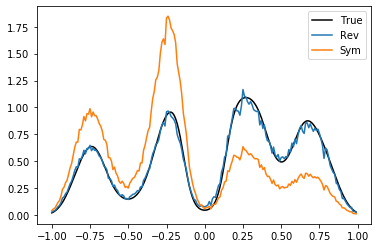

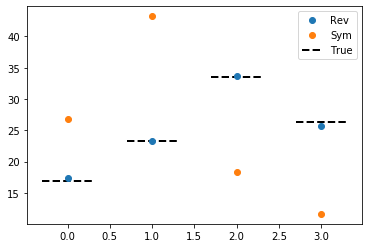

Error of rev: 0.8811040154420743, of sym: 5.0150186078936985


In [56]:
# check for the stationary distribution again
mu_result_rev = model_mu.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), '.', ms=12, label = "Rev")
plt.plot(np.abs(sym_states_prob), '.', ms=12, label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()
print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

### Plotting eigenfunctions for revVAMPnet

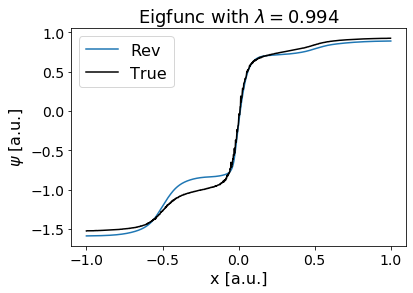

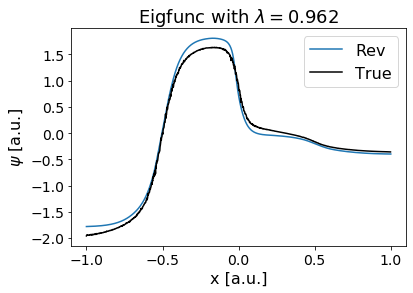

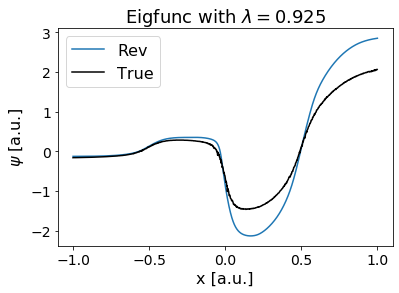

In [57]:
K_rev = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev)
sort_ind = np.argsort(eigvals_rev)[::-1]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={:.3}$'.format(true_eigvals[i]),fontsize=18)

    fac1 = true_eigfunc[0,i] / eigfunc_rev[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_rev[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend(fontsize=16)
    plt.xlabel('x [a.u.]', fontsize=16)
    plt.xticks([-1.,-.5,0,0.5,1.],fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylabel('$\psi$ [a.u.]', fontsize=16)
    plt.show()

## Training for revDMSM

### Initialization method

In [58]:
def optimize_u_dmsm(reset_chi=True):
    ''' 
    Calculate the optimal u for a given chi, and set the kernel of the corresponding layer
    to the optimal value. This is necessary to stabilize the training.
    Needs to be rewritten if the activation functions for the weights are changed!
    Uses another activation than revVAMPnet.
    '''
    if reset_chi:
        model_chi.set_weights(weights_chi)
    fullbatch = X1_train.shape[0]
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=fullbatch)
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    fullbatch = Data_chi_X.shape[0]
    
    
    c_0 = 1/fullbatch * Data_chi_X.T @ Data_chi_X
    c_tau = 1/fullbatch * Data_chi_X.T @ Data_chi_Y
    c_1 = 1/fullbatch * Data_chi_Y.T @ Data_chi_Y
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    
    # estimate pi, the stationary distribution vector
    eigv, eigvec = np.linalg.eig(K_vamp.T)
    ind_pi = np.argmin((eigv-1)**2)
    
    pi_vec = eigvec[:,ind_pi]
    pi = pi_vec / np.sum(pi_vec, keepdims=True)
        
    
    u_optimal = c0_inv @ pi
    u_kernel = np.log(np.abs(u_optimal))
    vamp_layer_u_msm.set_weights([u_kernel])
    
    return None

def optimize_S_dmsm(reset_chi=True):
    ''' 
    Calculate the optimal S for a given chi, and set the kernel of the corresponding layer
    to the optimal value. This is necessary to stabilize the training.
    Needs to be rewritten if the activation functions for the weights are changed!
    '''
    if reset_chi:
        model_chi.set_weights(weights_chi)
    fullbatch = X1_train.shape[0]
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=fullbatch)
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    fullbatch = Data_chi_X.shape[0]
    
    
    c_0 = 1/fullbatch * Data_chi_X.T @ Data_chi_X
    c_tau = 1/fullbatch * Data_chi_X.T @ Data_chi_Y
    c_1 = 1/fullbatch * Data_chi_Y.T @ Data_chi_Y
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    
    # get Sigma, invert it to get proxy S, meaning the closest symmetric S you can obtain to the optimal S
    
    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S_msm.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    
    eigv_all, eigvec_all = np.linalg.eigh(Sigma_input[0])
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    sigma_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    S_nonrev = K_vamp @ sigma_inv
    
    S_rev_add = 1/2 * (S_nonrev + S_nonrev.T)
    
    kernel_S = S_rev_add / 2.
    kernel_S = np.log(np.abs(kernel_S))
    
    vamp_layer_S_msm.set_weights([kernel_S])
            
    return None

In [59]:
optimize_u_dmsm()
optimize_S_dmsm()

In [60]:
Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]

Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]


model_both_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*10, clipnorm=1.),
             loss_vampe,
         )

hist = model_both_vampE_msm.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size = Data_chi_X.shape[0],
                 epochs = epoch_S,
                 validation_data = ([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose = 0,
                 callbacks = callbacks,
                 shuffle = True)

In [61]:
model_all_vampE_msm.compile(keras.optimizers.Adam(learning_rate=learning_rate*0.04, clipnorm=1.),
                 loss_vampe,
             )

hist = model_all_vampE_msm.fit(
    [whiten(X1_train), whiten(X2_train)],
    Y_train,
    batch_size = X1_train.shape[0],
    epochs = epoch_all,
    validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
    verbose = 0,
    callbacks = [EarlyStopping('val_loss', patience=50, mode='min', restore_best_weights=True)],
    shuffle = True
)

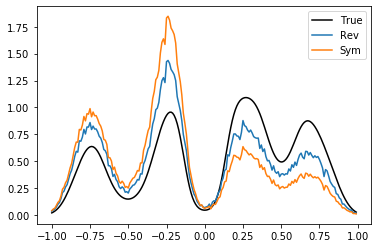

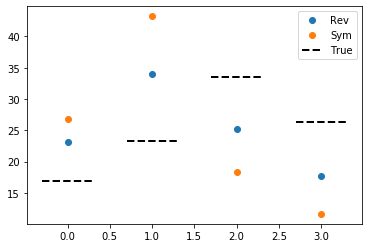

Error of rev: 2.838046737599744, of sym: 5.0150186078936985


In [62]:
K_result = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])

mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), '.', ms=12, label = "Rev")
plt.plot(np.abs(sym_states_prob), '.', ms=12, label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()

print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

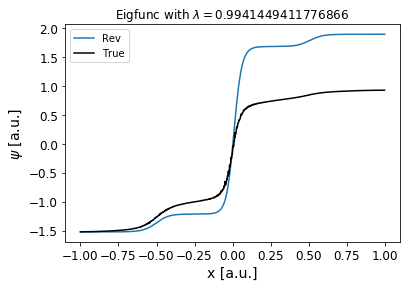

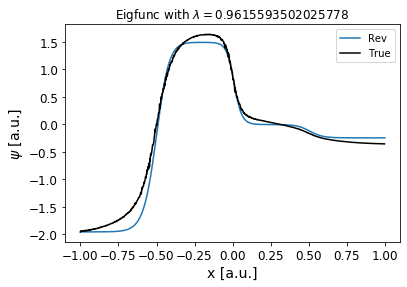

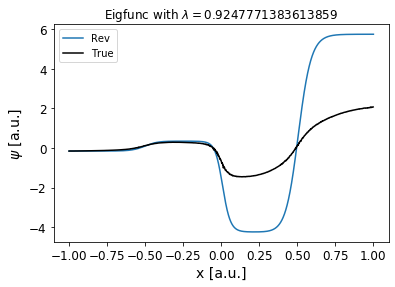

In [63]:
K_rev_msm = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev_msm)
sort_ind = np.argsort(eigvals_rev)[::-1]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev_msm1 = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={}$'.format(true_eigvals[i]))
    fac = true_eigfunc[0,i] / eigfunc_rev_msm1[0,i]
    plt.plot(xax, fac*eigfunc_rev_msm1[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend()
    plt.xlabel('x [a.u.]', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('$\psi$ [a.u.]', fontsize=14)
    plt.show()

In [64]:
score = 0.
weights_all = model_all_vampE.get_weights()
score_old = score

model_both_vampE_msm.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*100, clipnorm=1.),
    loss_vampe,
)

model_all_vampE_msm.compile(
    keras.optimizers.Adam(learning_rate=learning_rate*0.04, clipnorm=1.),
    loss_vampe,
)

while (score >= score_old):
    
    optimize_u_dmsm(reset_chi=False)

    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    
    Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
    Data_chi_X_vali = Data_chi_vali[:,:output_size]
    Data_chi_Y_vali = Data_chi_vali[:,output_size:]

    hist = model_both_vampE_msm.fit([Data_chi_X, Data_chi_Y], Y_train ,
                     batch_size = Data_chi_X.shape[0],
                     epochs = epoch_S,
                     validation_data = ([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                     verbose = 0,
                     callbacks = [EarlyStopping('val_loss', patience=50, mode='min', restore_best_weights=True)],
                     shuffle = True)
    
    hist = model_all_vampE_msm.fit(
        [whiten(X1_train), whiten(X2_train)],
        Y_train,
        batch_size = X1_train.shape[0],
        epochs = epoch_all,
        validation_data = ([whiten(X1_vali), whiten(X2_vali)], Y_vali ),
        verbose = 0,
        callbacks = callbacks,
        shuffle = True
    )

    score = - model_all_vampE_msm.evaluate([whiten(X1_vali), whiten(X2_vali)], batch_size = X1_vali.shape[0], verbose = 0)

    print('Old score {}, new score {}'.format(score_old, score))
    if (score>score_old):
        print('Score is better and weights are saved')
        score_old = score
        weights_all = model_all_vampE_msm.get_weights()
        
        
model_all_vampE_msm.set_weights(weights_all)
optimize_u_dmsm(reset_chi=False)

Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
Data_chi_X = Data_chi[:,:output_size]
Data_chi_Y = Data_chi[:,output_size:]

Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
Data_chi_X_vali = Data_chi_vali[:,:output_size]
Data_chi_Y_vali = Data_chi_vali[:,output_size:]

hist = model_both_vampE_msm.fit([Data_chi_X, Data_chi_Y], Y_train ,
                 batch_size=Data_chi_X.shape[0],
                 epochs = epoch_S,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=0,
                 callbacks=callbacks,
                 shuffle=True)


Old score 0.0, new score 3.7249302864074707
Score is better and weights are saved
Old score 3.7249302864074707, new score 3.7248692512512207


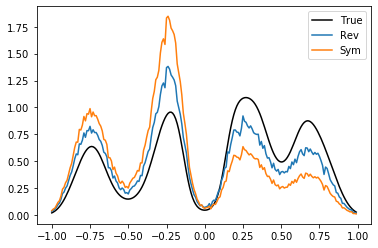

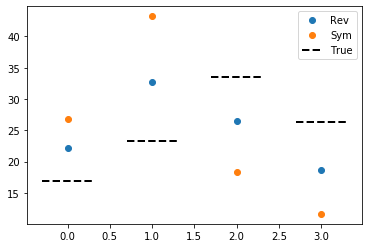

Error of rev: 2.49789350834939, of sym: 5.0150186078936985


In [65]:
mu_result_rev = model_mu_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
hist_rev, bin = np.histogram(X1_train.reshape(-1), bins=200, range=(-1,1), density=True, weights=mu_result_rev.reshape(-1))
prinz_en = data_generator.prinz_energy(bin[:-1])
prinz_stat = np.exp(-prinz_en/kT_prinz)
scaled_prinz_stat = prinz_stat / (prinz_stat.sum() * (bin[1]-bin[0]))       
plt.plot(bin[:-1], scaled_prinz_stat, label = 'True', c='k')
plt.plot(bin[:-1], hist_rev, label = 'Rev')
plt.plot(bin[:-1], hist_sym, label = 'Sym')
plt.legend()
plt.show()

rev_states_prob = np.sum(np.split(hist_rev, 4), 1)
sym_states_prob = np.sum(np.split(hist_sym, 4), 1)
tru_states_prob = np.sum(np.split(scaled_prinz_stat, 4), 1)
plt.plot(np.abs(rev_states_prob), '.', ms=12, label = "Rev")
plt.plot(np.abs(sym_states_prob), '.', ms=12, label = "Sym")
for j in range(4):
    legend=None
    if j>2:
        legend='True'
    plt.hlines(tru_states_prob[j], j-0.3, j+0.3, colors='k', linestyles='--', label=legend, lw=2)
plt.legend()
plt.show()
print('Error of rev: {}, of sym: {}'.format(np.linalg.norm(hist_rev - prinz_stat), np.linalg.norm(hist_sym - prinz_stat)))

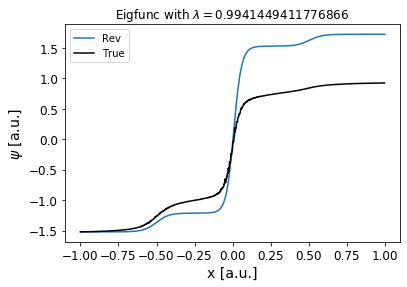

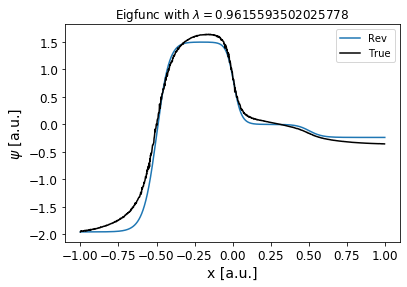

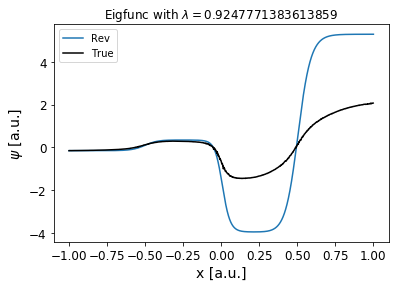

In [66]:
K_rev_msm = model_K_all_msm.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])[0]
eigvals_rev, eigvec_rev = np.linalg.eig(K_rev_msm)
sort_ind = np.argsort(eigvals_rev)[::-1]
# sort_ind = [2,1,3,0]
eigvals_rev = eigvals_rev[sort_ind]
eigvec_rev = eigvec_rev[:,sort_ind]

pred_xax = model_chi.predict([whiten(xax), whiten(xax)], batch_size=xax.shape[0])[:,:output_size]
eigfunc_rev_msm = pred_xax @ eigvec_rev
for i in range(1,output_size):
    plt.title('Eigfunc with $\lambda={}$'.format(true_eigvals[i]))
    fac = true_eigfunc[0,i] / eigfunc_rev_msm[0,i]
    plt.plot(xax, fac*eigfunc_rev_msm[:,i], label='Rev')
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', label='True')
    plt.legend()
    plt.xlabel('x [a.u.]', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel('$\psi$ [a.u.]', fontsize=14)
    plt.show()

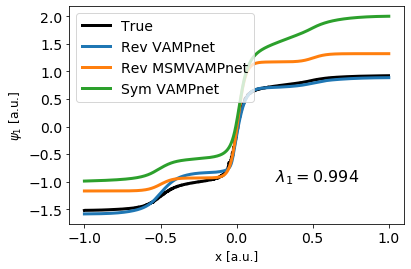

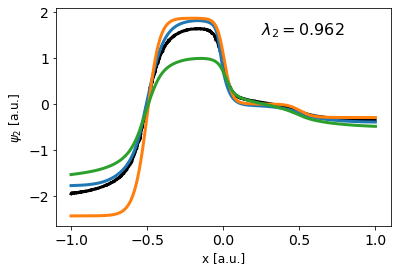

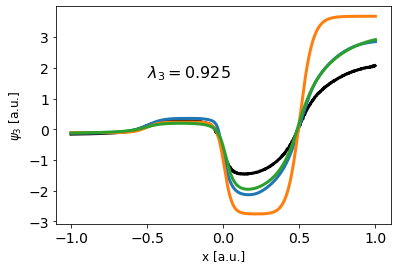

In [67]:
# compare all three methods for the eigenfunctions
x_pos = [0.25,0.25,-0.5]
y=[-1.,1.5,1.7]
fontsize2 = 14
fontsize1 = 12
for i in range(1,output_size):
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    plt.text(x_pos[i-1],y[i-1],'$\lambda_{}={:.3}$'.format(i,true_eigvals[i]), fontsize=fontsize2+2)
    plt.plot(xax[::10], true_eigfunc[:,i], 'k', lw=3, label='True')
    fac = true_eigfunc[index_al,i] / eigfunc_rev[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_rev[:,i], lw=3, label='Rev VAMPnet')
    
    
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    fac = true_eigfunc[index_al,i] / eigfunc_rev_msm[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_rev_msm[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_rev_msm[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_rev_msm[:,i], lw=3, label='Rev MSMVAMPnet')
    
    index_al = np.argmax(np.abs(true_eigfunc[:,i]))
    fac = true_eigfunc[index_al,i] / eigfunc_sym[index_al,i]
    fac1 = true_eigfunc[0,i] / eigfunc_sym[0,i]
    fac2 = true_eigfunc[-1,i] / eigfunc_sym[-1,i]
    fac = (fac1 + fac2)/2
    plt.plot(xax, fac*eigfunc_sym[:,i], lw=3, label='Sym VAMPnet')
    if i==1:
        plt.legend(fontsize=fontsize2)
    plt.xlabel('x [a.u.]', fontsize=fontsize1)
    plt.xticks([-1,-.5,0,.5,1], fontsize=fontsize2)
    plt.yticks(fontsize=fontsize2)
    plt.ylabel('$\psi_{}$ [a.u.]'.format(i), fontsize=fontsize1)
    plt.show()

In [68]:
# code to estimate the implied timescales for the revVAMPnet

def optimize_S_new_tau(factor_S, X1_train, X2_train):
    ''' 
    Calculate the optimal S for a given chi, and set the kernel of the corresponding layer
    to the optimal value. This is necessary to stabilize the training.
    Needs to be rewritten if the activation functions for the weights are changed!
    '''
    fullbatch = X1_train.shape[0]
        
    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=fullbatch)
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    fullbatch = Data_chi_X.shape[0]
    
    
    c_0 = 1/fullbatch * Data_chi_X.T @ Data_chi_X
    c_tau = 1/fullbatch * Data_chi_X.T @ Data_chi_Y
    c_1 = 1/fullbatch * Data_chi_Y.T @ Data_chi_Y
    
    eigv_all, eigvec_all = np.linalg.eigh(c_0)
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
        
    K_vamp = c0_inv @ c_tau
    
    # get Sigma, invert it to get proxy S, meaning the closest symmetric S you can obtain to the optimal S
    
    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    
    eigv_all, eigvec_all = np.linalg.eigh(Sigma_input[0])
    include = eigv_all > epsilon
    eigv = eigv_all[include]
    eigvec = eigvec_all[:,include]
    sigma_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    # reverse the construction of S
    S_nonrev = K_vamp @ sigma_inv
    S_rev_add = 1/2 * (S_nonrev + S_nonrev.T)
    kernel_S = S_nonrev / 2. / factor_S
    
    vamp_layer_S.set_weights([kernel_S])
        
    return None

def training_for_tau_both(new_tau):
    '''Estimate the Koopman matrix for a specific tau in order to estimate the
    implied timescales. Therefore, u and S have to be retrained for the new tau,
    while we keep chi fixed.'''
    
    # reestimate the training and validation data for the new tau
    traj_data_train = np.concatenate([traj[:-new_tau] for traj in training_trajs])
    traj_data_train_lag = np.concatenate([traj[new_tau:] for traj in training_trajs])

    traj_data_valid = np.concatenate([traj[:-new_tau] for traj in validation_trajs])
    traj_data_valid_lag = np.concatenate([traj[new_tau:] for traj in validation_trajs])

    # Input of the first network
    X1_train = traj_data_train.astype('float32')
    X2_train  = traj_data_train_lag.astype('float32')

    X1_vali = traj_data_valid.astype('float32')
    X2_vali  = traj_data_valid_lag.astype('float32')

    Y_train = np.zeros((X1_train.shape[0], output_size))
    Y_vali = np.zeros((X1_vali.shape[0], output_size))
    
    # reset S, u should not change to much
    reset_weights(vamp_layer_S.variables[0])
    # estimate a new guess
    optimize_S_new_tau(factor_S, X1_train, X2_train)
    
    model_S_vampE = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = VampE_matrix_S)
    adam = keras.optimizers.Adam(learning_rate=learning_rate*1000, )
    model_S_vampE.compile(adam, loss_vampe)

    model_K_S = keras.models.Model(inputs = [Data_v_keras, Data_C_00_keras, Data_C_11_keras, Data_C_01_keras, Data_Sigma_keras], outputs = K_S)

    Data_chi = model_chi.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])
    Data_chi_X = Data_chi[:,:output_size]
    Data_chi_Y = Data_chi[:,output_size:]
    Data_chi_vali = model_chi.predict([whiten(X1_vali), whiten(X2_vali)], batch_size=X1_vali.shape[0])
    Data_chi_X_vali = Data_chi_vali[:,:output_size]
    Data_chi_Y_vali = Data_chi_vali[:,output_size:]

    v_input, C_00_input, C_11_input, C_01_input, Sigma_input = model_input_S.predict([Data_chi_X, Data_chi_Y], batch_size=Data_chi_X.shape[0])
    v_input_vali, C_00_input_vali, C_11_input_vali, C_01_input_vali, Sigma_input_vali = model_input_S.predict([Data_chi_X_vali, Data_chi_Y_vali], batch_size=Data_chi_X_vali.shape[0])

    hist = model_S_vampE.fit([v_input[0][None], C_00_input[0][None], C_11_input[0][None], C_01_input[0][None], Sigma_input[0][None]], np.zeros_like(v_input[0][None]) ,
                 batch_size=v_input[0][None].shape[0],
                 epochs = epoch_S,
                 validation_data=([v_input_vali[0][None], C_00_input_vali[0][None], C_11_input_vali[0][None], C_01_input_vali[0][None], Sigma_input_vali[0][None]], np.zeros_like(v_input_vali[0][None])),
                 verbose=0,
                 callbacks=callbacks,
                 shuffle=True)

    adam = keras.optimizers.Adam(learning_rate=learning_rate*2, clipnorm=1.)
    model_both_vampE.compile(adam,
                     loss_vampe,
                     )
    model_K_both = keras.models.Model(inputs = [Data_chi_t_keras, Data_chi_tau_keras], outputs = K_both)
    hist = model_both_vampE.fit([Data_chi_X, Data_chi_Y], Y_train,
                 batch_size=Data_chi_X.shape[0],
                 epochs=epoch_all,
                 validation_data=([Data_chi_X_vali, Data_chi_Y_vali], Y_vali ),
                 verbose=0,
                 callbacks = [EarlyStopping('val_loss', patience=500, mode='min', restore_best_weights=True)],
                 shuffle=True)


    K_result = model_K_all.predict([whiten(X1_train), whiten(X2_train)], batch_size=X1_train.shape[0])

    return K_result[0]

In [69]:
model_all_vampE.set_weights(weights_chi_rev)
K_results_rev = np.ones((number_taus, output_size, output_size))
K_results = np.ones_like(K_results_rev)
for i, tau_i in enumerate(tau_list):
    print(tau_i)
    K_results_rev[i]= training_for_tau_both(tau_i)
    K_results[i]  = estimate_koopman_op(pred_ord_chi, tau_i, force_symmetric = True)

1
2
3
4
6
8
10


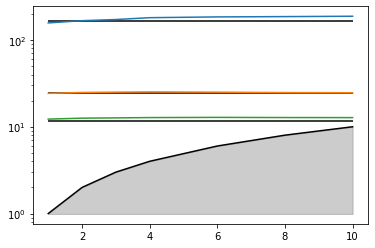

In [70]:
timescale_real_values = np.array([ 11.53593249,  24.48666445, 163.41165771])
for tsrv in timescale_real_values:
    plt.hlines(tsrv, tau_list[0], tau_list[-1])
vamp.plot_its(get_its(K_results_rev, tau_list, False), tau_list)

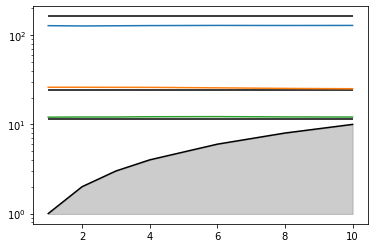

In [71]:
for tsrv in timescale_real_values:
    plt.hlines(tsrv, tau_list[0], tau_list[-1])
vamp.plot_its(get_its(K_results, tau_list, False), tau_list)